In [2]:
# inputs

#path to the .csv file created from the VeTrans output
haps_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/VeTrans/by_protein/n_haps_F/Inference_14_0.csv"

#path to the Times.in file
times = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/samfire/Times.in"

#name of the protein used for plotting
protein_name = "F Protein"


"F Protein"

In [3]:
# load Julia dependencies

using CSV
using DataFrames
using RCall
using Images
using FileIO
using FilePathsBase
using WebIO

# load R dependencies
R"""
# Function to set CRAN mirror and ensure R can download packages
chooseCRANmirror(ind=1) # Selects a default CRAN mirror

# Install the devtools package if not already installed
if (!requireNamespace("devtools", quietly = TRUE))
  install.packages("devtools")

# Load the devtools package
library(devtools)

# Install ggplot2 and viridis with dependencies
install.packages(c("ggplot2", "viridis", "tidyverse", "hrbrthemes", "plotly", "htmlwidgets"), dependencies = TRUE)

# Load the packages quietly
suppressPackageStartupMessages({
  library("ggplot2")
  library("viridis")
  library("tidyverse")
  library("hrbrthemes")
  library("plotly")
  library("htmlwidgets")
})
"""

┌ Warning: RCall.jl: Loading required package: usethis
└ @ RCall /Users/e.smith.5/.julia/packages/RCall/dDAVd/src/io.jl:172



The downloaded binary packages are in
	/var/folders/7v/htx5jcb93rvbnyr12j89csbr0000gp/T//Rtmp9m5vUS/downloaded_packages


┌ Warning: RCall.jl: Installing packages into '/Users/e.smith.5/Library/R/arm64/4.4/library'
│ (as 'lib' is unspecified)
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/ggplot2_3.5.1.tgz'
│ Content type 'application/x-gzip' length 4974305 bytes (4.7 MB)
│ ==================================================
│ downloaded 4.7 MB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/viridis_0.6.5.tgz'
│ Content type 'application/x-gzip' length 3016921 bytes (2.9 MB)
│ ==================================================
│ downloaded 2.9 MB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/tidyverse_2.0.0.tgz'
│ Content type 'application/x-gzip' length 428901 bytes (418 KB)
│ ==================================================
│ downloaded 418 KB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/hrbrthemes_0.8.7.tgz'
│ Content type 'application/x-gzip' length 862799 bytes (

RObject{StrSxp}
 [1] "htmlwidgets" "plotly"      "hrbrthemes"  "lubridate"   "forcats"    
 [6] "stringr"     "dplyr"       "purrr"       "readr"       "tidyr"      
[11] "tibble"      "tidyverse"   "viridis"     "viridisLite" "ggplot2"    
[16] "devtools"    "usethis"     "stats"       "graphics"    "grDevices"  
[21] "utils"       "datasets"    "methods"     "base"       


In [4]:
# load data

haps_wide = CSV.read(haps_path, DataFrame)

# pass into R
@rput haps_wide 

R"""
library(tidyverse)

times <- colnames(haps_wide)[-1]

haps <- haps_wide %>%
  pivot_longer(
    cols = all_of(times),
    names_to = "Time",
    values_to = "Frequency"
  )
"""

# get back haps dataframe

@rget haps

Row,Haplotype,Time,Frequency
,String,String,Float64
1,GGGCCCCCAATAAGCAATAACAAAGG,1,0.000108336
2,GGGCCCCCAATAAGCAATAACAAAGG,29,1.0e-10
3,GGGCCCCCAATAAGCAATAACAAAGG,50,0.000272864
4,GGGCCCCCAATAAGCAATAACAAAGG,74,1.0e-10
5,GGGCCCCCAATAAGCAATAACAAAGG,83,1.0e-10
6,GGGCCCCCAATAAGCAATAACAAAGG,99,2.44527e-5
7,GGGCCCCCAATAAGCAATAACAAAGG,111,1.0e-10
8,GGGCCCCCAATAAGCAATAACAAAGG,119,1.0e-10
9,GGGCCCCCAATAAGCAATAACAAAGG,125,0.0925662


In [5]:
# zero out smallest frequencies

@rput haps 

# R code to transform the Frequency column
R"""
library(tidyverse)

haps <- haps %>%
  mutate(Frequency = ifelse(Frequency <= 10e-10, 0, Frequency))
"""

@rget haps

Row,Haplotype,Time,Frequency
,String,String,Float64
1,GGGCCCCCAATAAGCAATAACAAAGG,1,0.000108336
2,GGGCCCCCAATAAGCAATAACAAAGG,29,0.0
3,GGGCCCCCAATAAGCAATAACAAAGG,50,0.000272864
4,GGGCCCCCAATAAGCAATAACAAAGG,74,0.0
5,GGGCCCCCAATAAGCAATAACAAAGG,83,0.0
6,GGGCCCCCAATAAGCAATAACAAAGG,99,2.44527e-5
7,GGGCCCCCAATAAGCAATAACAAAGG,111,0.0
8,GGGCCCCCAATAAGCAATAACAAAGG,119,0.0
9,GGGCCCCCAATAAGCAATAACAAAGG,125,0.0925662


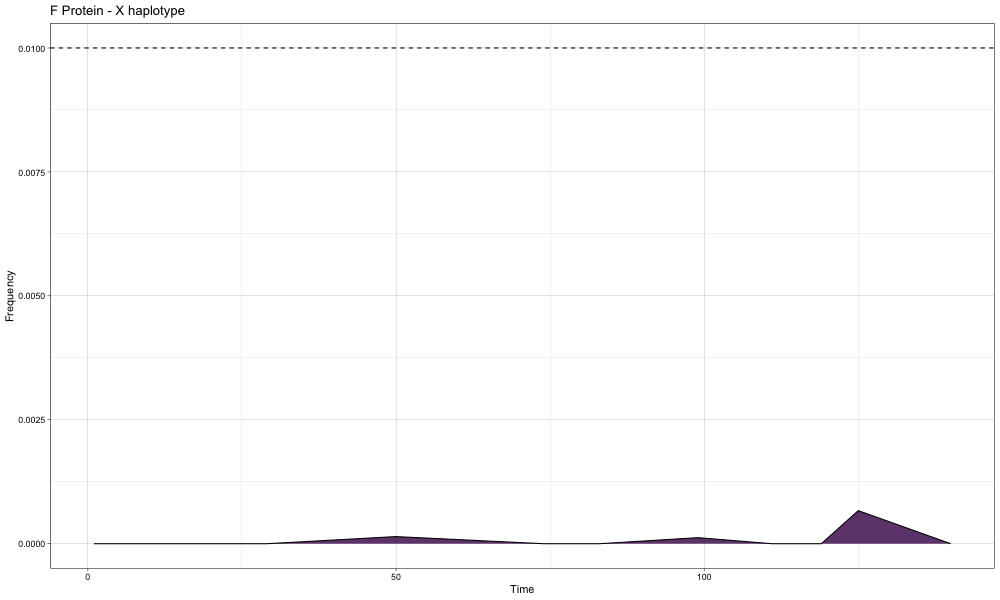

Temporary file deleted successfully.


In [6]:
# plot to check X haplotype frequencies

@rput haps # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""

p <- haps %>% filter(str_detect(Haplotype, "^X+$")) %>% 
    ggplot(aes(x = as.numeric(Time), y = as.numeric(Frequency), fill = Haplotype)) + 
    geom_area(alpha = 0.8, linewidth = 0.5, colour = "black") +
    geom_hline(yintercept = 0.01, linetype = "dashed", color = "black") +
    theme_linedraw() +
    labs(title = paste(protein_name, "- X haplotype"), x = "Time", y = "Frequency") +
    theme(legend.position = "none") +
    scale_fill_viridis(discrete = TRUE, direction = 1)

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

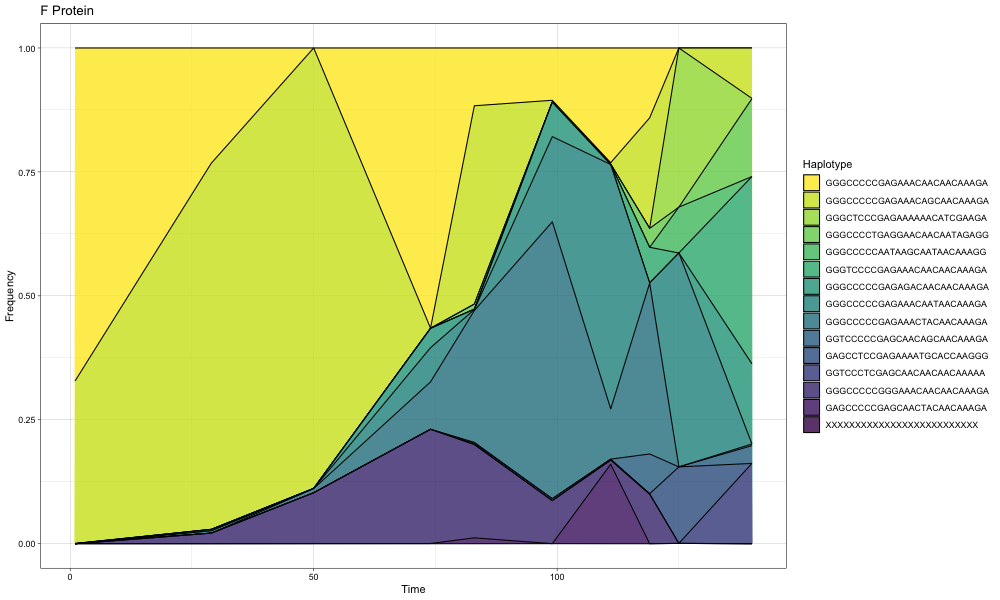

Temporary file deleted successfully.


In [7]:
# plot

@rput haps # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
# Sort haplotypes by their initial frequency
first_time_point <- haps %>% 
  filter(Time == min(Time)) %>% 
  arrange(desc(Frequency)) %>% 
  select(Haplotype, InitialFrequency = Frequency)

# Join the initial frequency data back to the main dataset
haps <- haps %>% 
  left_join(first_time_point, by = "Haplotype") %>%
  arrange(desc(InitialFrequency), Time, Frequency)

# Create a color palette with the same number of colors as unique haplotypes
num_haplotypes <- length(unique(haps$Haplotype))
haplotype_colors <- viridis::viridis(num_haplotypes, direction = -1)

# Assign colors based on the order of haplotypes by InitialFrequency
haps$Haplotype <- factor(haps$Haplotype, levels = unique(haps$Haplotype))

# Create the plot
p <- ggplot(haps, aes(x = as.numeric(Time), y = as.numeric(Frequency), fill = Haplotype)) + 
  geom_area(alpha = 0.8, linewidth = 0.5, colour = "black") +
  theme_linedraw() +
  labs(title = protein_name, x = "Time", y = "Frequency") +
  theme(legend.position = "right") +
  scale_fill_manual(values = haplotype_colors)


png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

In [8]:
# establish the consensus haplotype at time 0

# Function to find the consensus haplotype at the minimum time point
function consensus_haplotype(df::DataFrame)
    # Find the minimum time point
    min_time = minimum(df[!, :Time])
    
    # Filter the dataframe for the minimum time point
    filtered_df = filter(row -> row.Time == min_time, df)
    
    # Group by haplotype and sum their frequencies
    grouped_df = combine(groupby(filtered_df, :Haplotype), :Frequency => sum)
    
    # Find the haplotype with the maximum summed frequency
    max_freq_row = grouped_df[argmax(grouped_df[!, :Frequency_sum]), :]
    
    return max_freq_row.Haplotype
end

# Call the function and get the consensus haplotype
consensus = consensus_haplotype(haps)
println("The consensus haplotype at the first time point is: $consensus")

The consensus haplotype at the first time point is: GGGCCCCCGAGAAACAACAACAAAGA


In [9]:
# Function to calculate Hamming distance between two strings
function hamming_distance(s1::String, s2::String)::Int
    return sum(c1 != c2 for (c1, c2) in zip(s1, s2))
end

# Add new column with Hamming Distance
haps.ham_dist = [hamming_distance(row.Haplotype, consensus) for row in eachrow(haps)]

println(haps)

# Group the DataFrame by the 'Mismatches' column
@rput haps
R"""
# Grouping by Time and Mismatches, then summing Frequency
haps_dist <- haps %>%
    group_by(Time, ham_dist) %>%
    summarize(Frequency = sum(Frequency), .groups = 'drop')
"""

@rget haps_dist

150×4 DataFrame
 Row │ Haplotype                   Time    Frequency    ham_dist 
     │ String                      String  Float64      Int64    
─────┼───────────────────────────────────────────────────────────
   1 │ GGGCCCCCAATAAGCAATAACAAAGG  1       0.000108336         5
   2 │ GGGCCCCCAATAAGCAATAACAAAGG  29      0.0                 5
   3 │ GGGCCCCCAATAAGCAATAACAAAGG  50      0.000272864         5
   4 │ GGGCCCCCAATAAGCAATAACAAAGG  74      0.0                 5
   5 │ GGGCCCCCAATAAGCAATAACAAAGG  83      0.0                 5
   6 │ GGGCCCCCAATAAGCAATAACAAAGG  99      2.44527e-5          5
   7 │ GGGCCCCCAATAAGCAATAACAAAGG  111     0.0                 5
   8 │ GGGCCCCCAATAAGCAATAACAAAGG  119     0.0                 5
   9 │ GGGCCCCCAATAAGCAATAACAAAGG  125     0.0925662           5
  10 │ GGGCCCCCAATAAGCAATAACAAAGG  140     0.0                 5
  11 │ GGGTCCCCGAGAAACAACAACAAAGA  1       0.0                 1
  12 │ GGGTCCCCGAGAAACAACAACAAAGA  29      0.00278285          1
  13 │

Row,Time,ham_dist,Frequency
,String,Int64,Float64
1,1,0,0.671759
2,1,1,0.327615
3,1,3,0.0
4,1,4,0.000337723
5,1,5,0.000288598
6,1,8,0.0
7,1,26,0.0
8,111,0,0.231366
9,111,1,0.605561


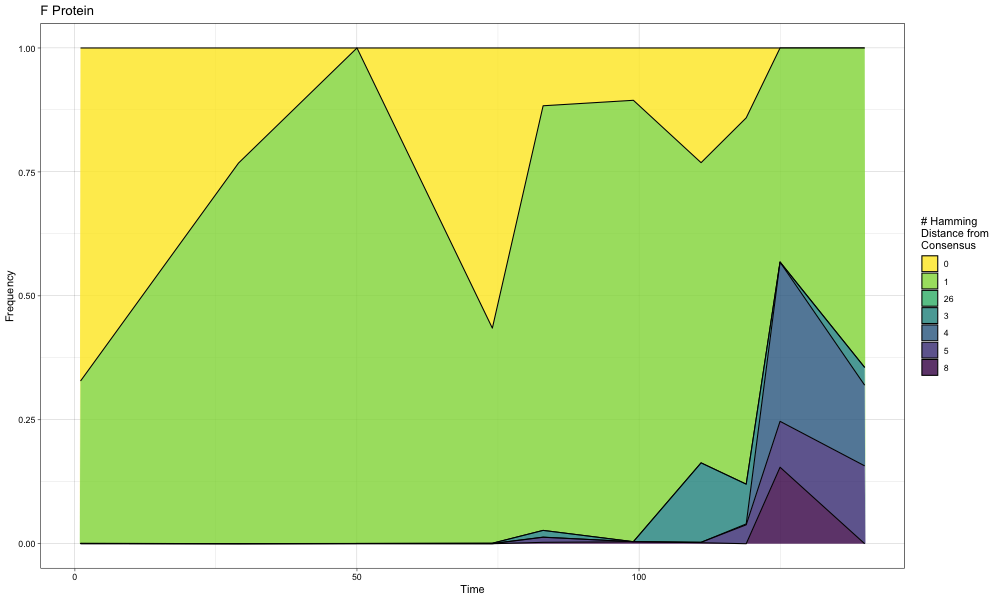

Temporary file deleted successfully.


In [10]:
# area plot for counts of mutations
# plot

@rput haps_dist # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
# Ensure columns are of correct types
haps_dist$Frequency <- as.numeric(unlist(haps_dist$Frequency))
haps_dist$ham_dist <- as.factor(as.character(unlist(haps_dist$ham_dist)))
haps_dist$Time <- as.numeric(unlist(haps_dist$Time))

p <- haps_dist %>% arrange(desc(Time)) %>% 
    ggplot(aes(x = as.numeric(Time), y = Frequency, fill = as.factor(ham_dist))) + 
    geom_area(alpha = 0.8 , linewidth = 0.5, colour = "black") +
    theme_linedraw() +
    labs(title = protein_name, x = "Time", y = "Frequency", fill = "# Hamming\nDistance from\nConsensus") +
    theme(legend.position = "right") +
    scale_fill_viridis(discrete = TRUE, direction = -1)

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
img = load(output_path)
display(img)

  
# Delete the temporary image file after displaying
rm(output_path; force = true)
println("Temporary file deleted successfully.")
else

println("File does not exist.")

end

The next plot requires input from Blanche (https://github.com/cjri/Blanche.git). 

In [11]:
using CSV
using DataFrames

# Define the file paths
blanche_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/Blanche/F/Consensus0_F_14_haplotypes.dat"
names_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/Blanche/F/Consensus0_F_14_haplotypes.txt"

# Read the .dat file and select the first two columns
df_coords = CSV.read(blanche_path, DataFrame; header=false, delim=" ", select=[1, 2])

# Read the .txt file containing the haplotype names
names = DataFrame(Haplotype=readlines(names_path))

# Combine the two DataFrames
blanche = hcat(df_coords, names)

# Rename the columns to "x", "y", and "Haplotype"
rename!(blanche, [:x, :y, :Haplotype])

# Find the coordinates of the consensus haplotype
consensus_coords = blanche[blanche.Haplotype .== consensus, [:x, :y]]
if nrow(consensus_coords) == 0
    error("Consensus haplotype not found in the dataframe.")
end

consensus_x, consensus_y = consensus_coords[1, :x], consensus_coords[1, :y]

# Compute the adjustment amounts
blanche.x .-= consensus_x
blanche.y .-= consensus_y

# Set the coordinates for the consensus haplotype to (0, 0)
blanche[blanche.Haplotype .== consensus, :x] .= 0.0
blanche[blanche.Haplotype .== consensus, :y] .= 0.0

# Join the updated coordinates with haps
haps = innerjoin(haps, blanche, on=:Haplotype)

# Display the joined dataframe
haps

Row,Haplotype,Time,Frequency,ham_dist,x,y
,String,String,Float64,Int64,Float64,Float64
1,GGGCCCCCAATAAGCAATAACAAAGG,1,0.000108336,5,-5.56282,-0.59667
2,GGGCCCCCAATAAGCAATAACAAAGG,29,0.0,5,-5.56282,-0.59667
3,GGGCCCCCAATAAGCAATAACAAAGG,50,0.000272864,5,-5.56282,-0.59667
4,GGGCCCCCAATAAGCAATAACAAAGG,74,0.0,5,-5.56282,-0.59667
5,GGGCCCCCAATAAGCAATAACAAAGG,83,0.0,5,-5.56282,-0.59667
6,GGGCCCCCAATAAGCAATAACAAAGG,99,2.44527e-5,5,-5.56282,-0.59667
7,GGGCCCCCAATAAGCAATAACAAAGG,111,0.0,5,-5.56282,-0.59667
8,GGGCCCCCAATAAGCAATAACAAAGG,119,0.0,5,-5.56282,-0.59667
9,GGGCCCCCAATAAGCAATAACAAAGG,125,0.0925662,5,-5.56282,-0.59667


In [12]:
# create mutation annotations for each haplotype

# path to single_locus_trajectories file
sl_traj_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/samfire/single_locus_trajectories/by_protein/single_locus_trajectories10_F_Fusion_protein.out"

using DataFrames

# Function to load the first column from the .out file into a DataFrame
# Function to create the loci DataFrame and add haplotype columns based on the `names` DataFrame
function create_base_loci(filepath::String, consensus::String, names::DataFrame)
    # Initialize an empty Set to store unique first column integers
    first_column_set = Set{Int}()

    # Open the file and read each line
    open(filepath, "r") do file
        for line in eachline(file)
            # Split the line by spaces and convert the first element to an integer
            push!(first_column_set, parse(Int, split(line)[1]))
        end
    end

    # Convert the Set to a sorted vector to create a DataFrame
    first_column_vector = sort(collect(first_column_set))
    
    # Check that the length of the consensus string matches the number of unique loci
    if length(first_column_vector) != length(consensus)
        error("The length of the consensus string must match the number of unique loci.")
    end

    # Create a DataFrame with the extracted unique integers and the consensus_base
    loci = DataFrame(locus = first_column_vector, consensus_base = collect(consensus))
    
    # Iterate over each row in the names DataFrame
    for row in eachrow(names)
        haplotype_string = row[:Haplotype]  # Get the sequence string from the Haplotype column
        column_name = haplotype_string  # Use the haplotype string as the column name

        # Initialize the new column with empty strings
        new_column = Vector{Union{Char, Nothing}}(nothing, length(loci.consensus_base))

        # Fill the new column, skipping matches with the consensus
        for j in 1:length(haplotype_string)
            if haplotype_string[j] != loci.consensus_base[j]
                new_column[j] = haplotype_string[j]
            end
        end

        # Add the new column to the loci DataFrame
        loci[!, Symbol(column_name)] = new_column
    end
    
    return loci
end

# Load the first row of the single_locus_trajectories file
loci = create_base_loci(sl_traj_path, consensus, names)

loci


Row,locus,consensus_base,GGGCCCCCAATAAGCAATAACAAAGG,GGGTCCCCGAGAAACAACAACAAAGA,GGGCCCCCGAGAGACAACAACAAAGA,GGGCCCCCGAGAAACAATAACAAAGA,GGGCCCCCGAGAAACAGCAACAAAGA,GGGCCCCCGAGAAACTACAACAAAGA,GGTCCCCCGAGCAACAGCAACAAAGA,GAGCCTCCGAGAAAATGCACCAAGGG,GGTCCCTCGAGCAACAACAACAAAAA,GGGCCCCCGGGAAACAACAACAAAGA,GGGCCCCTGAGGAACAACAATAGAGG,GGGCCCCCGAGAAACAACAACAAAGA,GAGCCCCCGAGCAACTACAACAAAGA,GGGCTCCCGAGAAAAAACATCGAAGA
,Int64,Char,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…
1,5778,G,,,,,,,,,,,,,,
2,5882,G,,,,,,,,A,,,,,A,
3,5899,G,,,,,,,T,,T,,,,,
4,5925,C,,T,,,,,,,,,,,,
5,6005,C,,,,,,,,,,,,,,T
6,6148,C,,,,,,,,T,,,,,,
7,6169,C,,,,,,,,,T,,,,,
8,6223,C,,,,,,,,,,,T,,,
9,6280,G,A,,,,,,,,,,,,,


In [13]:
# create dataframe of variant positions per haplotype

# Melt the DataFrame to long format, excluding `locus` and `consensus_base`
melted = stack(loci, Not([:locus, :consensus_base]), variable_name=:haplotype, value_name=:variant_base)

# Define a function to check for undesired values
is_valid_variant(value) = !ismissing(value) && value ≠ "N/A" && value ≠ nothing

# Filter out rows where `variant_base` is missing, "N/A", or nothing
filtered = filter(row -> is_valid_variant(row.variant_base), melted)

# Select only relevant columns
variant_loci = filtered[:, [:locus, :consensus_base, :haplotype, :variant_base]]

# Create the 'variant' column by concatenating values
variant_loci.variant = string.(variant_loci.consensus_base) .* string.(variant_loci.locus) .* string.(variant_loci.variant_base)

# Filter for only helpful columns
variant_loci = variant_loci[:, [:haplotype, :variant]]

# Group by "haplotype" and concatenate "variant" values with newline separator
grouped = groupby(variant_loci, :haplotype)
variant_loci_merged = combine(grouped, :variant => (v -> join(v, "\n")))

# Rename the merged column
rename!(variant_loci_merged, :variant_function => :variant)

# Rename haplotype column for joining
rename!(variant_loci_merged, :haplotype => :Haplotype)



Row,Haplotype,variant
,String,String
1,GGGCCCCCAATAAGCAATAACAAAGG,G6280A\nG6302T\nA6378G\nC6528T\nA7174G
2,GGGTCCCCGAGAAACAACAACAAAGA,C5925T
3,GGGCCCCCGAGAGACAACAACAAAGA,A6306G
4,GGGCCCCCGAGAAACAATAACAAAGA,C6528T
5,GGGCCCCCGAGAAACAGCAACAAAGA,A6518G
6,GGGCCCCCGAGAAACTACAACAAAGA,A6507T
7,GGTCCCCCGAGCAACAGCAACAAAGA,G5899T\nA6305C\nA6518G
8,GAGCCTCCGAGAAAATGCACCAAGGG,G5882A\nC6148T\nC6450A\nA6507T\nA6518G\nA6548C\nA7038G\nA7174G
9,GGTCCCTCGAGCAACAACAACAAAAA,G5899T\nC6169T\nA6305C\nG7042A


In [14]:
# join variant_loci to grouped_haps for annotation

haps = leftjoin(haps, variant_loci_merged, on=:Haplotype)


Row,Haplotype,Time,Frequency,ham_dist,x,y,variant
,String,String,Float64,Int64,Float64,Float64,String?
1,GGGCCCCCAATAAGCAATAACAAAGG,1,0.000108336,5,-5.56282,-0.59667,G6280A\nG6302T\nA6378G\nC6528T\nA7174G
2,GGGCCCCCAATAAGCAATAACAAAGG,29,0.0,5,-5.56282,-0.59667,G6280A\nG6302T\nA6378G\nC6528T\nA7174G
3,GGGCCCCCAATAAGCAATAACAAAGG,50,0.000272864,5,-5.56282,-0.59667,G6280A\nG6302T\nA6378G\nC6528T\nA7174G
4,GGGCCCCCAATAAGCAATAACAAAGG,74,0.0,5,-5.56282,-0.59667,G6280A\nG6302T\nA6378G\nC6528T\nA7174G
5,GGGCCCCCAATAAGCAATAACAAAGG,83,0.0,5,-5.56282,-0.59667,G6280A\nG6302T\nA6378G\nC6528T\nA7174G
6,GGGCCCCCAATAAGCAATAACAAAGG,99,2.44527e-5,5,-5.56282,-0.59667,G6280A\nG6302T\nA6378G\nC6528T\nA7174G
7,GGGCCCCCAATAAGCAATAACAAAGG,111,0.0,5,-5.56282,-0.59667,G6280A\nG6302T\nA6378G\nC6528T\nA7174G
8,GGGCCCCCAATAAGCAATAACAAAGG,119,0.0,5,-5.56282,-0.59667,G6280A\nG6302T\nA6378G\nC6528T\nA7174G
9,GGGCCCCCAATAAGCAATAACAAAGG,125,0.0925662,5,-5.56282,-0.59667,G6280A\nG6302T\nA6378G\nC6528T\nA7174G


In [15]:
# plotly 

@rput haps

# Set the path for saving the html file
html_path = replace(haps_path, ".csv" => "_points.html")

folder_path = dirname(html_path)

@rput html_path
@rput folder_path

# Create the ggplot
R"""

# Ensure Time is numeric
haps$Time <- as.numeric(as.character(haps$Time))


# Unique sorted time points
time_points <- sort(unique(haps$Time))

# Calculate frame delays manually
frame_delays <- numeric(length(time_points) - 1)
for (i in 2:length(time_points)) {
  frame_delays[i - 1] <- time_points[i] - time_points[i - 1]
}

# Add 0 for the first frame (initial delay)
frame_delays <- c(0, frame_delays)

#add tooltip text 
haps <- haps %>%
  mutate(tooltip_text = ifelse(is.na(variant),
                               paste("Consensus<br>Frequency:", Frequency, ham_dist),
                               paste(variant, "<br>Frequency:", Frequency, ham_dist)))


# Create the ggplot
p <- ggplot(haps, aes(x = x, y = y, color = ham_dist, size = ifelse(Frequency > 0, Frequency, NA), lavel = variant)) + 
    geom_point(aes(frame = Time)) +
    theme_linedraw() +
    labs(title = protein_name, x = "Dimension 1", y = "Dimension 2",
        size = "Frequency\n", color = "Hamming\nDistance from\nConsensus",
        frame = "TIme") +
    guides(size = guide_legend(title.position = "top")) +
    theme(legend.position = "bottom") +
    guides(colour = guide_colourbar(title.position = "top", title.theme = element_text(hjust = 0.5))) +
    theme(legend.title = element_text(hjust = 0)) +
    scale_color_viridis(direction = -1) +
    scale_size_continuous(range = c(0, 20)) +
    ylim(min(haps$y) - 0.5, max(haps$y) + 0.5) +
    xlim(min(haps$x) - 0.5, max(haps$x) + 0.5)

# Convert ggplot to plotly
p_plotly <- ggplotly(p)


setwd(folder_path) #trick to get single file html
htmlwidgets::saveWidget(p_plotly, html_path, selfcontained = TRUE)
setwd("/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/src") # reset to original directory
"""

print(haps)



┌ Warning: RCall.jl: Warning in geom_point(aes(frame = Time)) :
│   Ignoring unknown aesthetics: frame
└ @ RCall /Users/e.smith.5/.julia/packages/RCall/dDAVd/src/io.jl:172


140×7 DataFrame
 Row │ Haplotype                   Time    Frequency    ham_dist  x          y          variant                           
     │ String                      String  Float64      Int64     Float64    Float64    String?                           
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ GGGCCCCCAATAAGCAATAACAAAGG  1       0.000108336         5  -5.56282   -0.59667   G6280A\nG6302T\nA6378G\nC6528T\n…
   2 │ GGGCCCCCAATAAGCAATAACAAAGG  29      0.0                 5  -5.56282   -0.59667   G6280A\nG6302T\nA6378G\nC6528T\n…
   3 │ GGGCCCCCAATAAGCAATAACAAAGG  50      0.000272864         5  -5.56282   -0.59667   G6280A\nG6302T\nA6378G\nC6528T\n…
   4 │ GGGCCCCCAATAAGCAATAACAAAGG  74      0.0                 5  -5.56282   -0.59667   G6280A\nG6302T\nA6378G\nC6528T\n…
   5 │ GGGCCCCCAATAAGCAATAACAAAGG  83      0.0                 5  -5.56282   -0.59667   G6280A\nG6302T\nA6378G\nC6528T\n…
   6 

In [16]:
# try using plot_ly()

@rput haps

R"""
# Get working directory for resetting later
library(dplyr)
library(plotly)

# Get working directory for resetting later
home_wd <- getwd()

# Generate Day column for plotting
haps <- haps %>%
  mutate(
    tooltip_text = ifelse(is.na(variant),
                          paste("Consensus"),  # Show only "Consensus" when variant is NA
                          paste(variant)),  # Show only the variant when it's not NA
    Day = as.numeric(Time)  # Ensure Time is numeric and assign it to Day
  )

# Function to interpolate the size (Frequency) between days without moving the points
interpolate_sizes <- function(data, n = 10) {
  full_data <- data.frame()
  
  unique_days <- sort(unique(data$Day))
  
  for (i in seq_along(unique_days)[-length(unique_days)]) {
    start_day <- unique_days[i]
    end_day <- unique_days[i + 1]
    
    day_seq <- seq(start_day, end_day, length.out = n)
    
    start_data <- data %>% filter(Day == start_day)
    end_data <- data %>% filter(Day == end_day)
    
    for (j in seq_along(day_seq)) {
      fraction <- (day_seq[j] - start_day) / (end_day - start_day)
      
      interp_data <- start_data %>%
        mutate(
          Day = day_seq[j],
          Frequency = (1 - fraction) * Frequency + fraction * end_data$Frequency
        )
      
      full_data <- rbind(full_data, interp_data)
    }
  }
  
  return(full_data)
}

# Interpolate between sizes for smooth animation
haps_interpolated <- interpolate_sizes(haps, n = 10)  # n = number of frames to interpolate between each Day

# Define the original time points present in the data
original_times <- sort(unique(haps$Day))

# Generate the smooth animation without slider and without Frequency in hovertext
p_smooth <- plot_ly(haps_interpolated, 
                    x = ~x, 
                    y = ~y, 
                    size = ~ifelse(Frequency > 0, Frequency, NA),
                    color = ~-ham_dist, 
                    frame = ~Day,  # Use interpolated 'Day' as the frame for the animation
                    type = 'scatter',
                    mode = 'markers',
                    text = ~tooltip_text,  # Use updated tooltip_text without Frequency
                    hoverinfo = 'text',
                    marker = list(sizemode = 'diameter'),  # Specify marker settings
                    sizes = c(0, 100)) %>%  # Set the minimum and maximum marker sizes
  hide_colorbar() %>%  # Hide the colorbar
  layout(title = protein_name,
         xaxis = list(title = 'Dimension 1', 
                      range = c(min(haps$x) - 0.5, max(haps$x) + 0.5)),
         yaxis = list(title = 'Dimension 2', 
                      range = c(min(haps$y) - 0.5, max(haps$y) + 0.5)),
         updatemenus = list(
           list(
             type = "buttons",
             direction = "left",
             x = 0.1,
             y = 1.2,
             showactive = TRUE,
             buttons = list(
               list(
                 label = "Play",
                 method = "animate",
                 args = list(NULL, list(mode = "immediate", 
                                        transition = list(duration = 0, easing = "linear"), 
                                        frame = list(duration = 30, redraw = FALSE)))
               ),
               list(
                 label = "Pause",
                 method = "animate",
                 args = list(NULL, list(mode = "immediate", 
                                        transition = list(duration = 0), 
                                        frame = list(duration = 0, redraw = FALSE)))
               )
             )
           )
         )
  ) %>%
  animation_opts(
    frame = 30,
    transition = 0,
    easing = "linear",
    redraw = FALSE,
    mode = "immediate"
  ) %>%
  animation_slider(hide = TRUE)  # Hide the slider

# Save the smooth animation without slider
smooth_html_path <- sub(".html", "_smooth.html", html_path)
setwd(folder_path)  # Trick to get single file HTML
htmlwidgets::saveWidget(p_smooth, smooth_html_path, selfcontained = TRUE)

# Generate the non-interpolated animation with slider
p_slider <- plot_ly(haps, 
                    x = ~x, 
                    y = ~y, 
                    size = ~ifelse(Frequency > 0, Frequency, NA),
                    color = ~-ham_dist, 
                    frame = ~Day,  # Use original 'Day' as the frame for the animation
                    type = 'scatter',
                    mode = 'markers',
                    text = ~tooltip_text,
                    hoverinfo = 'text',
                    marker = list(sizemode = 'diameter'),  # Specify marker settings
                    sizes = c(0, 100)) %>%  # Set the minimum and maximum marker sizes
  hide_colorbar() %>%  # Hide the colorbar
  layout(title = protein_name,
         xaxis = list(title = 'Dimension 1', 
                      range = c(min(haps$x) - 0.5, max(haps$x) + 0.5)),
         yaxis = list(title = 'Dimension 2', 
                      range = c(min(haps$y) - 0.5, max(haps$y) + 0.5)),
         updatemenus = list(
           list(
             type = "buttons",
             showactive = FALSE,
             buttons = list(
               list(
                 label = "Play",
                 method = "animate",
                 args = list(NULL, list(mode = "immediate", 
                                        transition = list(duration = 0, easing = "linear"), 
                                        frame = list(duration = 500, redraw = TRUE)))
               ),
               list(
                 label = "Pause",
                 method = "animate",
                 args = list(NULL, list(mode = "immediate", 
                                        transition = list(duration = 0), 
                                        frame = list(duration = 0, redraw = FALSE)))
               )
             )
           )
         ),
         sliders = list(list(
           active = 0,
           steps = lapply(original_times, function(time) {
             list(
               label = paste("Day", time),
               method = "animate",
               args = list(list(frame = list(duration = 0, redraw = TRUE), mode = "immediate"),
                           list(frame = as.character(time)))
             )
           }),
           currentvalue = list(prefix = "Day: ", font = list(size = 20, color = "black")),
           pad = list(t = 50),
           x = 0.1,
           len = 0.9
         )))

# Save the non-interpolated animation with slider
slider_html_path <- sub(".html", "_slider.html", html_path)
setwd(folder_path)  # Trick to get single file HTML
htmlwidgets::saveWidget(p_slider, slider_html_path, selfcontained = TRUE)

# Construct and return the output messages
output_messages <- paste(
  "Smooth file saved at", smooth_html_path, ". This can be opened in your browser.",
  "Slider file saved at", slider_html_path, ". This can be opened in your browser."
)

# Reset the working directory
setwd(home_wd)

# Return the messages as output
output_messages
"""

┌ Warning: RCall.jl: Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does not currently support multiple values.
│ Warning: `line.width` does 

RObject{StrSxp}
[1] "Smooth file saved at /Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/VeTrans/by_protein/n_haps_F/Inference_14_0_points_smooth.html . This can be opened in your browser. Slider file saved at /Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/VeTrans/by_protein/n_haps_F/Inference_14_0_points_slider.html . This can be opened in your browser."
